In [3]:
import torch

In [1]:
words = open('names.txt', 'r').read().splitlines()
words[:2]

['emma', 'olivia']

In [19]:
min(len(w) for w in words)

2

In [4]:
g = torch.Generator().manual_seed(2147483647)

In [17]:
train_size = int(0.8 * len(words))
test_size = int(0.1 * len(words))
dev_size = len(words) - (train_size+test_size)
train, dev, test = torch.utils.data.random_split(words, [train_size, dev_size, test_size])

In [18]:
len(words), len(train), len(test), len(dev)

(32033, 25626, 3203, 3204)

In [25]:
N = torch.zeros((27*27,27), dtype=torch.int32)

chars = sorted(list(set(''.join(words)))) # getting the list of all unique characters in the dataset in sorted order(a-z)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

for w in words:
    chs = ['.'] + list(w) + ['.'] # adding the special start and end characters
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[27*ix1+ix2, ix3] += 1

In [39]:
N.shape

torch.Size([729, 27])

In [44]:
P = (N+1).float()
P /= P.sum(dim=1, keepdim=True)

In [45]:
P[0, :].sum()

tensor(1.)

In [46]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[27*ix1+ix2, ix3]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f"{log_likelihood=}")
print(f"nll = {-log_likelihood}")
print(f"norm nll = {-log_likelihood/n}")

log_likelihood=tensor(-410414.9688)
nll = 410414.96875
norm nll = 2.092747449874878


In [53]:
P

tensor([[0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
        [0.0002, 0.0469, 0.0430,  ..., 0.0063, 0.0392, 0.0345],
        [0.0008, 0.1275, 0.0008,  ..., 0.0008, 0.0038, 0.0008],
        ...,
        [0.0714, 0.0357, 0.0357,  ..., 0.0357, 0.0357, 0.0357],
        [0.2011, 0.1609, 0.0057,  ..., 0.0057, 0.0057, 0.0115],
        [0.0694, 0.1944, 0.0139,  ..., 0.0139, 0.1111, 0.0139]])

In [54]:
import random

In [59]:
for i in range(2):
    row_idx = random.randint(1,26)
    print(row_idx)

11
19


In [65]:
g = torch.Generator().manual_seed(2147483647)
random.seed(2147483647)
names = []

for i in range(10):
    row_idx = random.randint(1,26)
    char = itos[row_idx] 
    name = char
    idx1 = row_idx
    while char != '.':
        p = P[row_idx, :]
        idx2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        # print(idx2)
        char = itos[idx2]
        # print(char)
        name += char
        row_idx = 27*idx1+idx2
        idx1 = idx2
    print(name)
    names.append(name)

khur.
daxx.
grenavissyn.
jobhon.
wikataib.
khdivery.
asie.
zia.
ron.
gel.


### Neural Network based method

In [118]:
# creating the training set of examples
xs , ys = [], []
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append((ix1,ix2))
        ys.append(ix3)
        print(f'{ch1}{ch2} -> {ch3}')

xs = torch.tensor(xs)
ys = torch.tensor(ys)

.e -> m
em -> m
mm -> a
ma -> .


In [119]:
xs,ys

(tensor([[ 0,  5],
         [ 5, 13],
         [13, 13],
         [13,  1]]),
 tensor([13, 13,  1,  0]))

In [120]:
import torch.nn.functional as F
num_classes = 27
xenc = torch.cat([F.one_hot(xs[:, 0], num_classes=num_classes),
                  F.one_hot(xs[:, 1], num_classes=num_classes)], dim=1).float() # casting to float as nn work with continuous numeric inputs
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [121]:
xenc.shape

torch.Size([4, 54])

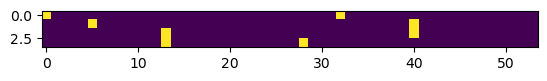

In [114]:
plt.imshow(xenc)

In [100]:
# creating 27 neurons with weights instialized randomly
W = torch.rand((54,27))
(xenc @ W) # (5x54) @ (54x27) = (5x27) (for each input activation of all 27 neurons)

tensor([[0.5978, 0.3356, 0.5786, 0.8807, 0.5856, 1.7991, 0.6113, 0.3452, 1.1852,
         0.7767, 0.3590, 1.1629, 0.8756, 1.0262, 1.2016, 0.6726, 1.0825, 0.8145,
         1.0160, 1.0780, 1.2979, 0.9438, 1.7528, 0.5156, 1.9046, 1.9612, 0.8580],
        [0.5437, 1.2590, 0.7740, 1.1043, 0.8463, 0.2554, 1.3184, 0.7464, 1.9034,
         0.4161, 1.5267, 1.4233, 1.0296, 1.1407, 1.7127, 0.6222, 1.6935, 0.6522,
         1.2033, 0.5601, 1.4115, 0.7167, 1.1423, 1.2992, 1.6432, 0.1882, 0.3667],
        [1.1100, 1.5333, 0.3809, 0.4420, 1.0938, 1.1458, 1.3691, 1.3634, 1.7844,
         0.8290, 1.4311, 1.3325, 0.4111, 1.2367, 1.7418, 1.0438, 1.2482, 1.2467,
         0.2838, 0.9503, 0.9053, 0.7962, 0.2923, 0.8774, 0.9498, 0.6804, 0.5005],
        [1.8115, 1.5663, 0.8463, 0.3307, 1.3895, 1.4165, 0.6767, 0.8702, 1.1565,
         1.1369, 0.8956, 0.8232, 0.4459, 0.6501, 0.9696, 0.9515, 0.6746, 0.9228,
         0.1355, 1.2152, 1.1566, 0.8740, 0.4955, 0.7112, 0.6295, 1.4023, 0.6585]])

In [102]:
logits = (xenc @ W) # log-counts
counts = logits.exp() # equivalent N
probs = counts / torch.sum(counts, 1, keepdim=True) # probabilities for the next character
probs

tensor([[0.0228, 0.0175, 0.0223, 0.0302, 0.0225, 0.0757, 0.0231, 0.0177, 0.0410,
         0.0272, 0.0179, 0.0401, 0.0301, 0.0350, 0.0417, 0.0245, 0.0370, 0.0283,
         0.0346, 0.0368, 0.0459, 0.0322, 0.0723, 0.0210, 0.0841, 0.0890, 0.0295],
        [0.0206, 0.0422, 0.0260, 0.0362, 0.0279, 0.0155, 0.0448, 0.0253, 0.0804,
         0.0182, 0.0552, 0.0498, 0.0336, 0.0375, 0.0665, 0.0223, 0.0652, 0.0230,
         0.0399, 0.0210, 0.0492, 0.0245, 0.0376, 0.0439, 0.0620, 0.0145, 0.0173],
        [0.0380, 0.0580, 0.0183, 0.0195, 0.0374, 0.0394, 0.0492, 0.0489, 0.0745,
         0.0287, 0.0524, 0.0474, 0.0189, 0.0431, 0.0714, 0.0355, 0.0436, 0.0435,
         0.0166, 0.0324, 0.0309, 0.0277, 0.0168, 0.0301, 0.0324, 0.0247, 0.0206],
        [0.0839, 0.0656, 0.0319, 0.0191, 0.0550, 0.0565, 0.0270, 0.0327, 0.0436,
         0.0427, 0.0336, 0.0312, 0.0214, 0.0263, 0.0361, 0.0355, 0.0269, 0.0345,
         0.0157, 0.0462, 0.0436, 0.0328, 0.0225, 0.0279, 0.0257, 0.0557, 0.0265]])

In [103]:
probs.shape

torch.Size([4, 27])

In [105]:
nlls = torch.zeros(4)
for i in range(4):
  # i-th bigram:
  x1, x2 = xs[i][0].item(), xs[i][1].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x1]}{itos[x2]}{itos[y]} (indexes {x1},{x2},{y})')
  print('input to the neural net:', (x1,x2))
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .em (indexes 0,5,13)
input to the neural net: (0, 5)
output probabilities from the neural net: tensor([0.0228, 0.0175, 0.0223, 0.0302, 0.0225, 0.0757, 0.0231, 0.0177, 0.0410,
        0.0272, 0.0179, 0.0401, 0.0301, 0.0350, 0.0417, 0.0245, 0.0370, 0.0283,
        0.0346, 0.0368, 0.0459, 0.0322, 0.0723, 0.0210, 0.0841, 0.0890, 0.0295])
label (actual next character): 13
probability assigned by the net to the the correct character: 0.03495420888066292
log likelihood: -3.3537163734436035
negative log likelihood: 3.3537163734436035
--------
bigram example 2: emm (indexes 5,13,13)
input to the neural net: (5, 13)
output probabilities from the neural net: tensor([0.0206, 0.0422, 0.0260, 0.0362, 0.0279, 0.0155, 0.0448, 0.0253, 0.0804,
        0.0182, 0.0552, 0.0498, 0.0336, 0.0375, 0.0665, 0.0223, 0.0652, 0.0230,
        0.0399, 0.0210, 0.0492, 0.0245, 0.0376, 0.0439, 0.0620, 0.0145, 0.0173])
label (actual next character): 13
probability assigned by the net to the the

In [122]:
xenc.shape

torch.Size([4, 54])

In [123]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27), generator=g, requires_grad=True)

In [140]:
# forward pass
num_classes = 27
xenc = torch.cat([F.one_hot(xs[:, 0], num_classes=num_classes),
                  F.one_hot(xs[:, 1], num_classes=num_classes)], dim=1).float()
logits = xenc @ W
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True)
loss = -probs[torch.arange(4), ys].log().mean()

In [141]:
loss

tensor(3.8845, grad_fn=<NegBackward>)

In [142]:
# backwards pass
W.grad = None # set to zero gradient
loss.backward()

In [143]:
# update
W.data += -0.1 * W.grad

In [152]:
def create_dataset(words):
        # dataset
        xs , ys = [], []
        for w in words:
            chs = ['.'] + list(w) + ['.']
            for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = stoi[ch1]
                ix2 = stoi[ch2]
                ix3 = stoi[ch3]
                xs.append([ix1,ix2])
                ys.append(ix3)

        xs = torch.tensor(xs)
        ys = torch.tensor(ys)
        num_1 = xs.shape[0]
        num_2 = ys.nelement()
        print(num_1, num_2)
        return xs, ys, num_1

# Model Training
xs_train, ys_train, num_train = create_dataset(words)

196113 196113


In [156]:

# # initializing the network
W = torch.randn((54,27), generator=g, requires_grad=True)
print(W)

# # gradient descent
for k in range(150):
    # forward pass
    xenc = torch.cat([F.one_hot(xs_train[:,0], num_classes=27),
                        F.one_hot(xs_train[:,1], num_classes=27)],dim=1).float()
    logits = xenc @ W # log-counts
    counts = logits.exp()
    probs = counts/counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(num_train), ys_train].log().mean() + 0.01*(W**2).mean() # nll + regularisation
    print(f"Loss at iteration {k+1} : {loss}")

    # backwards pass
    W.grad = None # set to zero gradient
    loss.backward()

    # update
    W.data += -40 * W.grad

tensor([[-0.0248,  0.5203, -1.8783,  ..., -0.2901,  0.0437, -0.4449],
        [-0.6851, -1.2949,  1.6538,  ...,  0.2800,  0.1134,  1.2624],
        [-0.0205, -0.6873,  0.9004,  ...,  0.3653, -1.9820,  0.8117],
        ...,
        [ 2.3286,  0.9181,  1.0550,  ...,  0.4955,  0.3674, -0.1687],
        [-0.4859, -1.4310,  0.2528,  ...,  0.2638, -1.5383,  0.3591],
        [ 0.1135, -0.4826, -0.8430,  ...,  0.5211,  0.4590, -0.7903]],
       requires_grad=True)
Loss at iteration 1 : 4.167153358459473
Loss at iteration 2 : 3.487342119216919
Loss at iteration 3 : 3.177805185317993
Loss at iteration 4 : 2.9976861476898193
Loss at iteration 5 : 2.875115394592285
Loss at iteration 6 : 2.786677122116089
Loss at iteration 7 : 2.7198877334594727
Loss at iteration 8 : 2.66743540763855
Loss at iteration 9 : 2.6250784397125244
Loss at iteration 10 : 2.5901150703430176
Loss at iteration 11 : 2.5607123374938965
Loss at iteration 12 : 2.5355911254882812
Loss at iteration 13 : 2.5138447284698486
Loss at i

In [157]:
W

tensor([[-3.3845,  2.4490, -0.2068,  ..., -1.2826,  0.6379,  0.3838],
        [ 1.3693,  0.9898,  0.0648,  ..., -1.3017,  0.2562,  0.0183],
        [ 0.2546,  1.5845,  0.2096,  ...,  0.0942,  0.6071, -0.1656],
        ...,
        [ 1.2108,  0.6588,  0.5350,  ...,  1.2588,  0.5984,  0.1321],
        [ 1.6412,  1.5217, -0.7105,  ..., -0.8067, -1.8990, -0.1341],
        [ 0.4080,  1.7619, -0.9265,  ..., -0.0640,  1.2845,  0.0047]],
       requires_grad=True)

In [158]:
names = []
for i in range(10):
    out = []
    ix1 = 0
    ix2 = random.randint(1,26)
    out.append(itos[ix2])
    # ix2 = 0
    while True:
        xenc = torch.cat([F.one_hot(torch.tensor([ix1]), num_classes=27),
                    F.one_hot(torch.tensor([ix2]), num_classes=27)],dim=1).float()
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character
        
        ix1 = ix2
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix2])
        if ix2 == 0:
            break
    print(''.join(out))

lye.
rieynna.
ana.
quilikardyna.
xa.
elaistoratenthylironeleen.
breylesip.
pre.
wishob.
vebexi.
